In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
train_data_dir = 'dataset/train'
test_data_dir = 'dataset/test'
img_height, img_width = 64, 64
batch_size = 16

In [4]:
# here the data augmentation training set
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)


In [5]:
# here the data generator for training set
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 100 images belonging to 2 classes.


In [6]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 38 images belonging to 2 classes.


In [7]:
# This Function is to create the CNN model
def create_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model
model = create_model((img_height, img_width, 3))

In [8]:
# here Compilation of the model completed
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [9]:
#train the model
history = model.fit(train_generator, epochs=20, validation_data=test_generator)


Epoch 1/20
7/7 [==============================] - 18s 2s/step - loss: 0.7251 - accuracy: 0.4600 - val_loss: 0.6867 - val_accuracy: 0.5000
Epoch 2/20
7/7 [==============================] - 14s 2s/step - loss: 0.6916 - accuracy: 0.5000 - val_loss: 0.6868 - val_accuracy: 0.7105
Epoch 3/20
7/7 [==============================] - 12s 2s/step - loss: 0.6864 - accuracy: 0.5800 - val_loss: 0.6675 - val_accuracy: 0.5000
Epoch 4/20
7/7 [==============================] - 13s 2s/step - loss: 0.6700 - accuracy: 0.6100 - val_loss: 0.6239 - val_accuracy: 0.7105
Epoch 5/20
7/7 [==============================] - 13s 2s/step - loss: 0.6318 - accuracy: 0.7100 - val_loss: 0.5788 - val_accuracy: 0.7895
Epoch 6/20
7/7 [==============================] - 13s 2s/step - loss: 0.6145 - accuracy: 0.6800 - val_loss: 0.5643 - val_accuracy: 0.6316
Epoch 7/20
7/7 [==============================] - 13s 2s/step - loss: 0.5858 - accuracy: 0.7200 - val_loss: 0.5165 - val_accuracy: 0.7895
Epoch 8/20
7/7 [==================

In [10]:
model.save('blur_sharp_model.h5')


evaluation = model.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

3/3 [==============================] - 3s 870ms/step - loss: 0.4624 - accuracy: 0.7895
Test Accuracy: 78.95%


In [11]:
# confusion Matrix and Classification Report
y_true = test_generator.classes
y_pred = model.predict(test_generator).flatten()

# convert probabilities to binary predictions
y_pred_binary = np.round(y_pred)

# confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_binary)

# classification Report
class_report = classification_report(y_true, y_pred_binary, target_names=['blur_image', 'sharp_image'])


print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)



3/3 [==============================] - 3s 950ms/step
Confusion Matrix:
[[10  9]
 [ 7 12]]

Classification Report:
              precision    recall  f1-score   support

  blur_image       0.59      0.53      0.56        19
 sharp_image       0.57      0.63      0.60        19

    accuracy                           0.58        38
   macro avg       0.58      0.58      0.58        38
weighted avg       0.58      0.58      0.58        38



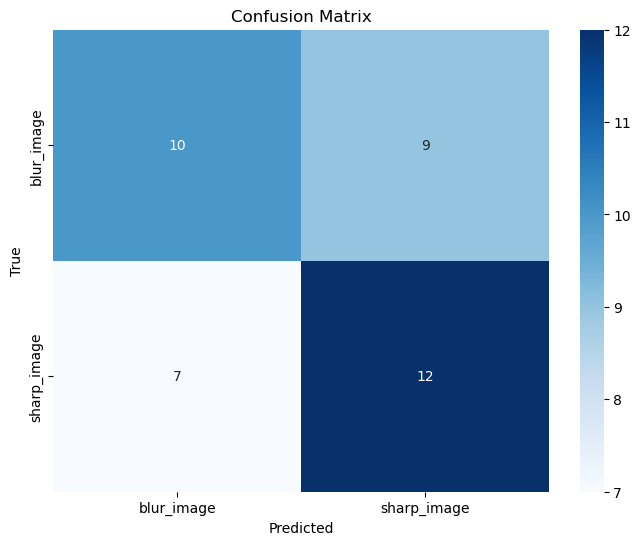

In [12]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['blur_image', 'sharp_image'],
            yticklabels=['blur_image', 'sharp_image'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

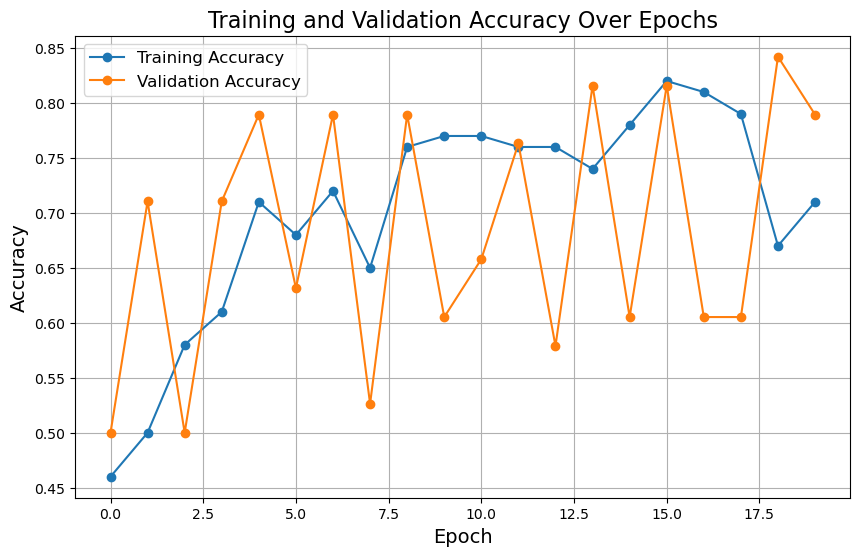

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Training and Validation Accuracy Over Epochs', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [14]:
def load_and_preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((img_height, img_width))
    img_array = np.array(img)
    img_array = img_array / 255.0  
    img_array = np.expand_dims(img_array, axis=0)  
    return img_array


In [15]:
loaded_model = models.load_model('blur_sharp_model.h5')

In [16]:
#test_image_path = 'dataset/test/sharp_image/s1.jpg'
test_image_path = 'dataset/test/blur_image/b4.jpg'

 


test_image = load_and_preprocess_image(test_image_path)
prediction = loaded_model.predict(test_image)

1/1 [==============================] - 0s 149ms/step


In [17]:
# now convert prediction to class label
class_label = "blur_image" if prediction < 0.5 else "sharp_image"
print(f"The predicted class is: {class_label}")

The predicted class is: blur_image
